# Bike Sharing Analysis

### Importing the required libraries

In [1]:
# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Sci-kit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

import numpy as np
import pandas as pd
from math import sqrt
import pickle


### Reading the CSV input file as a Pandas DataFrame

In [2]:
data_raw=pd.read_csv('hour.csv')

### Viewing a sample of the data

In [3]:
data_raw.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Deleting the index and dateday column

In [4]:
del data_raw['instant']
del data_raw['dteday']

### Analysing the data types of each column

In [5]:
data_raw.dtypes

season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

### Converting and setting up the appropriate data types to each column in the dataframe

In [6]:
for col in ['season', 'yr', 'mnth', 'hr','holiday','weekday','workingday','weathersit']:
    data_raw[col] = data_raw[col].astype('category')

### Getting an overview of the dataframe

In [7]:
data_raw.describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


### Null value check in the DataFrame

In [8]:
data_raw.isnull().sum().sum()

0

### Box plot to understand the target variable

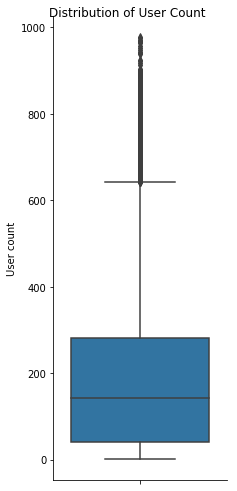

In [9]:
g=sns.catplot(y="cnt", kind="box", data=data_raw)
g.fig.set_size_inches(3,7)
g.fig.suptitle('Distribution of User Count')
g.set_ylabels('User count')

### Removing outliers for the target variable beyond 2.5 standard deviations

In [10]:
data = data_raw[np.abs(data_raw["cnt"]-data_raw["cnt"].mean())<=(2.5*data_raw["cnt"].std())]


### Correlation Matrix

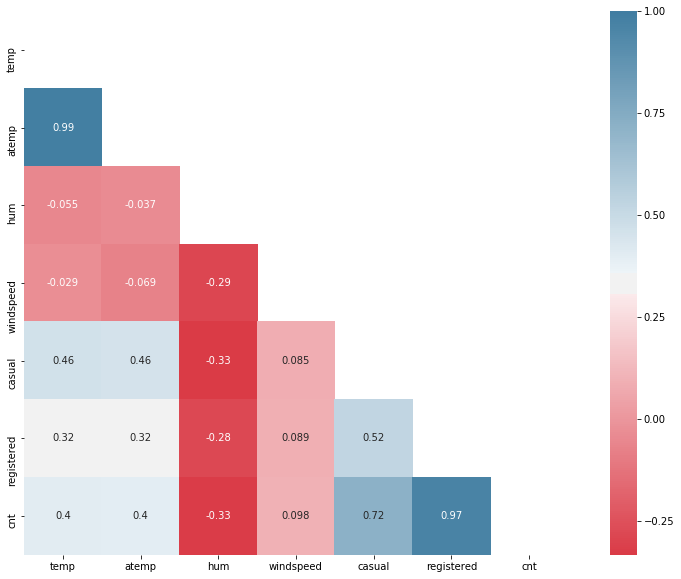

In [11]:
f, ax = plt.subplots(figsize=(15, 10))

# Creating correlation matrix
correlation = data.corr()

# Setting up a mask to hide the upper triangle in the matrix
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# Creating the Seaborn heatmap
sns.heatmap(correlation, mask=mask, 
            cmap=sns.diverging_palette(10,235,center='light',as_cmap=True),
            square=True, ax=ax,annot=True)

- We are able to infer that variables like temperature and humidity are highly correlated with user count.
- Multicollinearity problem exists between temp and atemp.
- Windspeed is the least important feature with regard to user count.

### Dropping the temp feature as temp and temp are multicollinear

In [12]:
del data['temp']

### Dropping the casual and registered users feature as it is higly correlated with count feature

In [13]:
del data['casual']
del data['registered']

### Visualizing the distribution of the user count

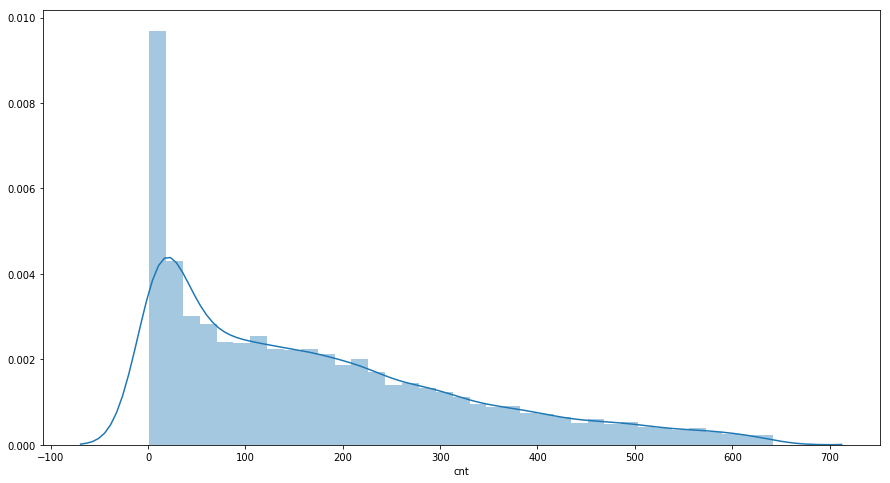

In [14]:
f, ax = plt.subplots(figsize=(15, 8))
sns.distplot(data['cnt'])

- We can see that the distribution is skewed towards the right
- A log transformation would fix this skewness

### Taking log transformation to overcome the skewness observed from the above plot

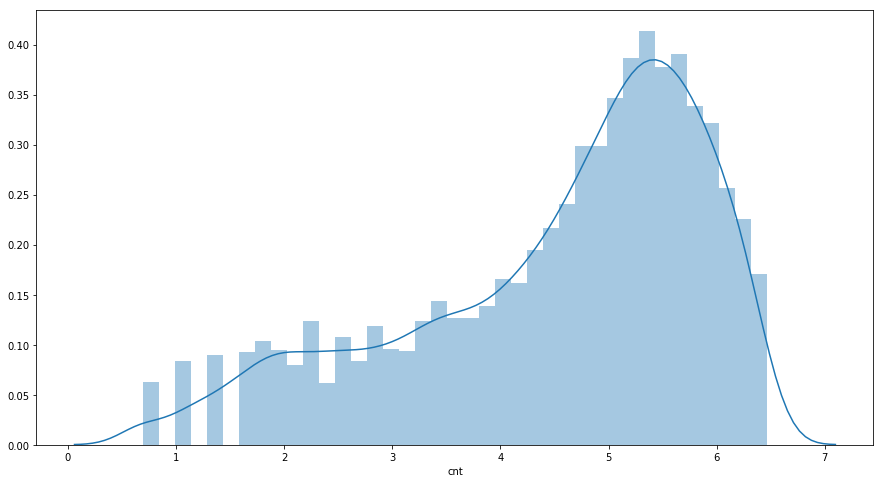

In [15]:
f, ax = plt.subplots(figsize=(15, 8))
sns.distplot(np.log1p(data['cnt']))

### Scatter plot of user count against humidity

C:\Users\Surya\Anaconda2\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


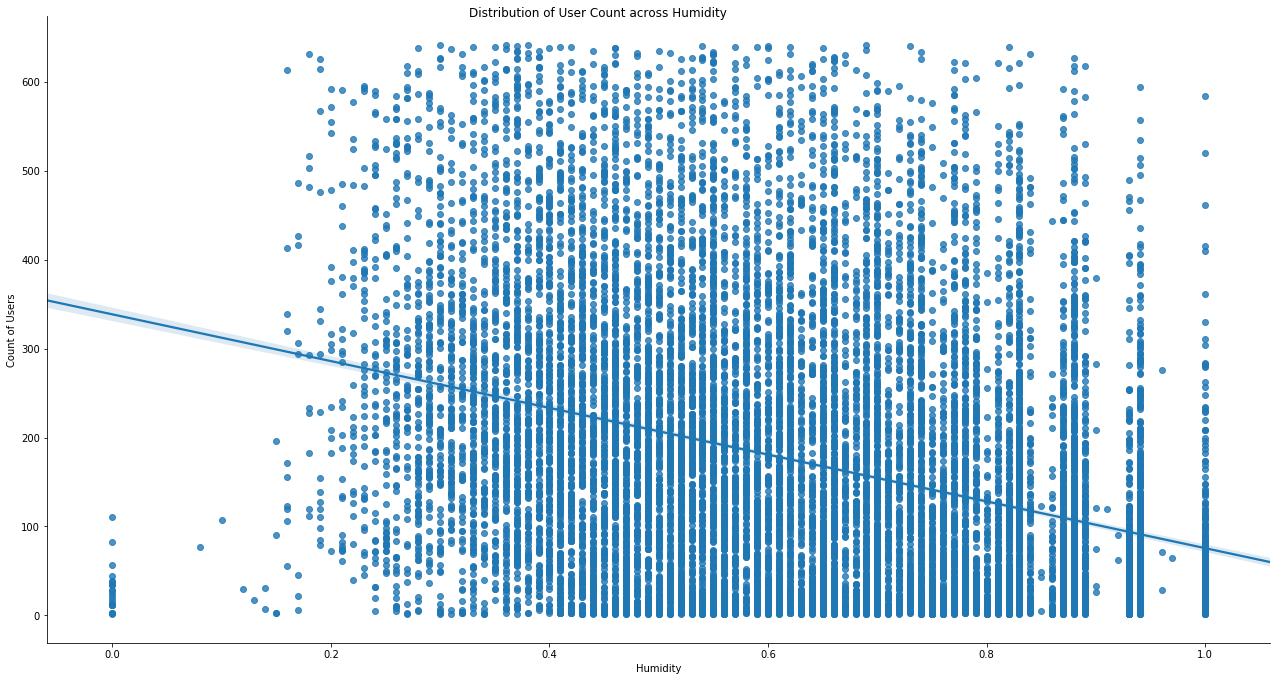

In [16]:
g=sns.lmplot(x="hum", y="cnt",data=data,palette="deep",size=6,markers=["o"])
g.fig.set_size_inches(20,10)
g.fig.suptitle('Distribution of User Count across Humidity')
g.set_xlabels('Humidity')
g.set_ylabels('Count of Users')

### Scatter plot of user count against temperature

C:\Users\Surya\Anaconda2\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


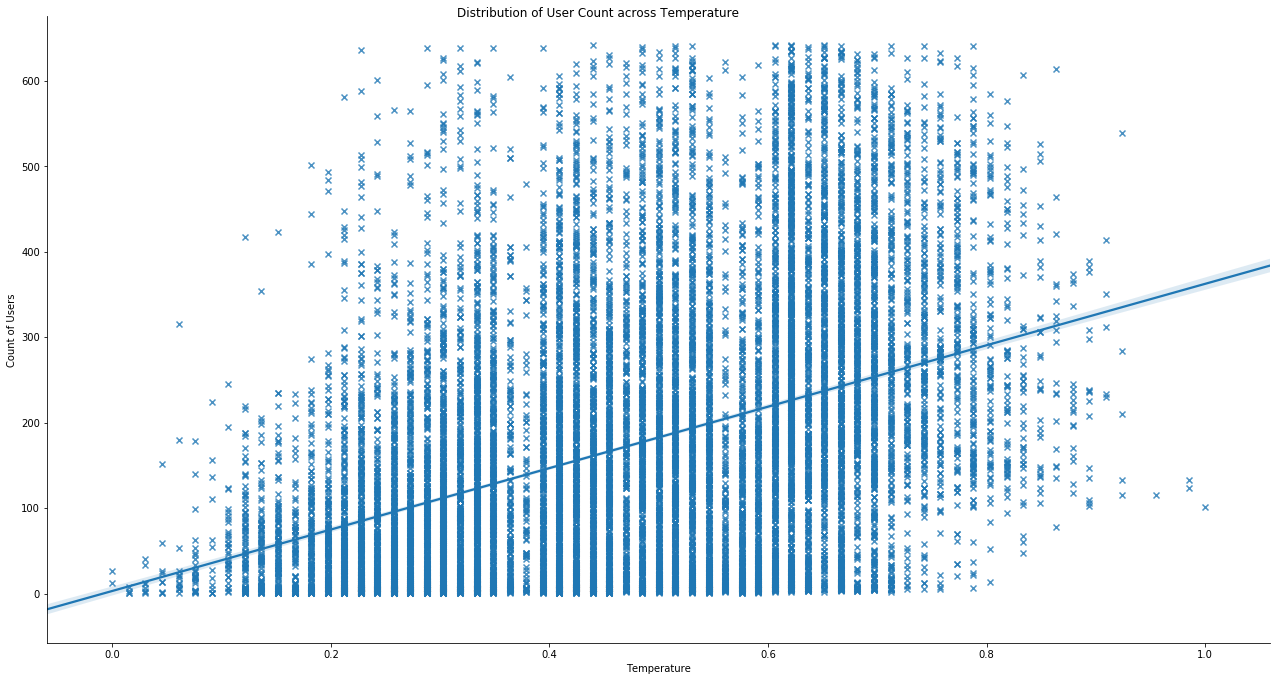

In [17]:
g=sns.lmplot(x="atemp", y="cnt",data=data,palette="deep",size=6,markers=["x"])
g.fig.set_size_inches(20,10)
g.fig.suptitle('Distribution of User Count across Temperature')
g.set_xlabels('Temperature')
g.set_ylabels('Count of Users')

### Visualizing the distribution of the user count by month

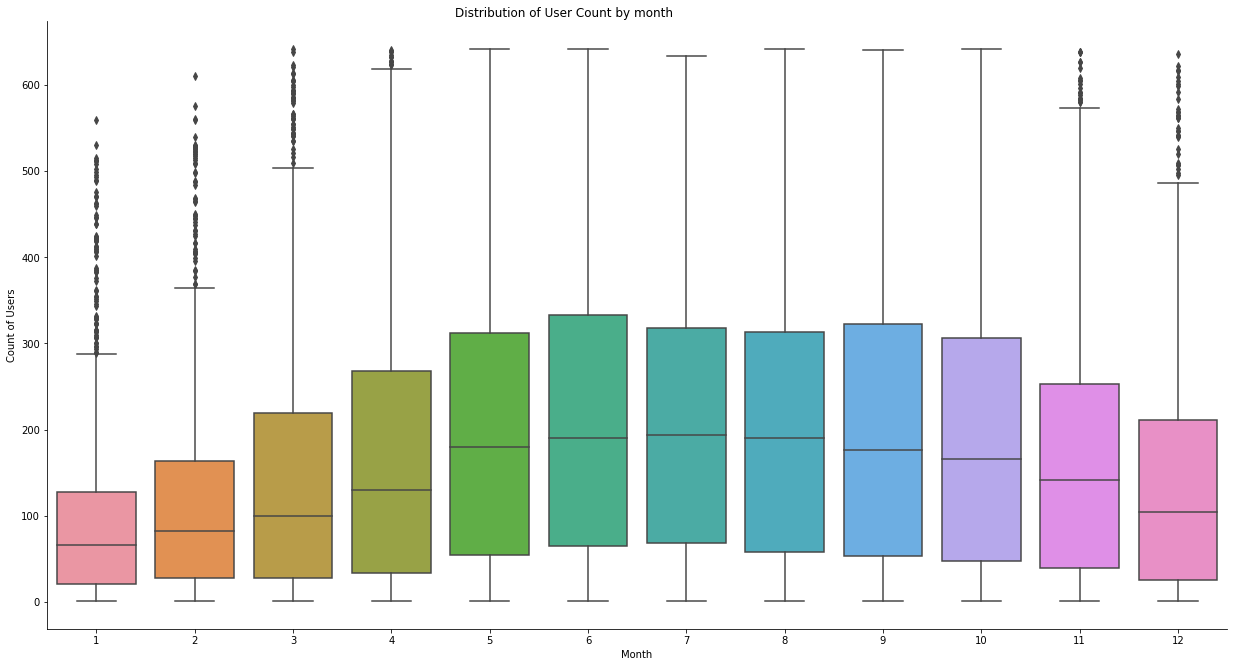

In [18]:
g=sns.catplot(x="mnth", y="cnt", kind="box", data=data)
g.fig.set_size_inches(20,10)
g.fig.suptitle('Distribution of User Count by month')
g.set_xlabels('Month')
g.set_ylabels('Count of Users')

- We are able to infer that the demand is comparatively high in Summer (May, June and July).

### Visualizing the spread of user count by hour of the day across seasons

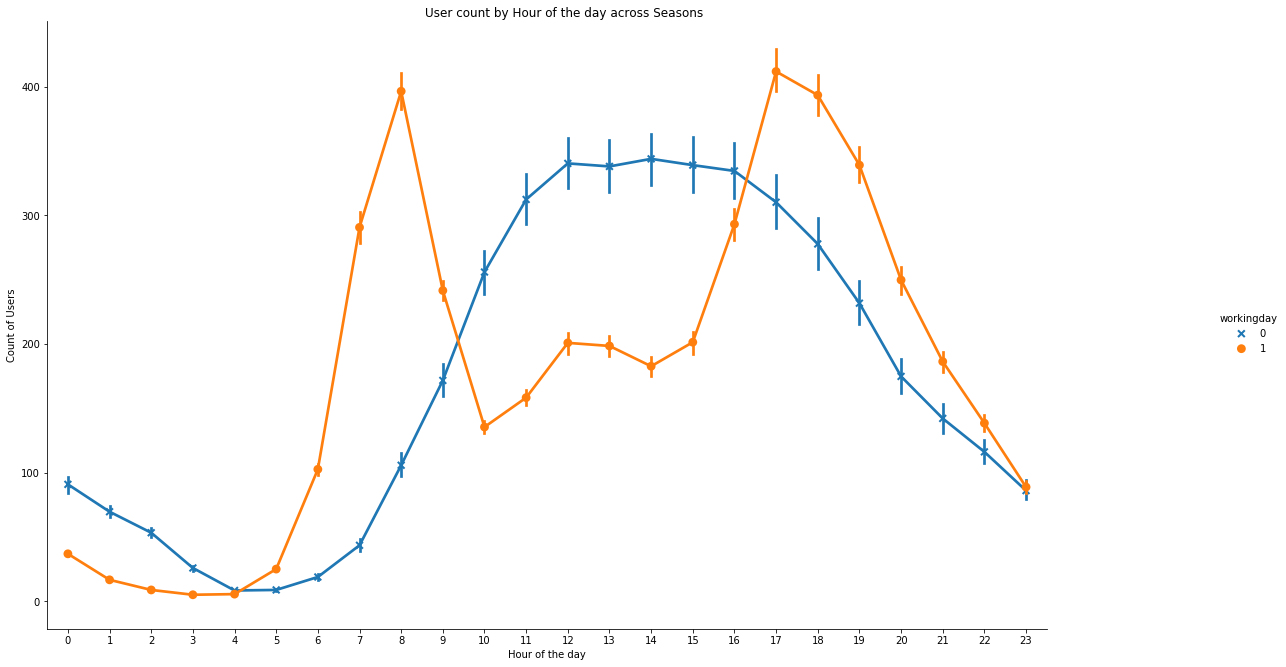

In [19]:
g=sns.catplot(x="hr", y="cnt",hue="workingday", kind="point", data=data,markers=["x","o","^","|"])
g.fig.set_size_inches(20,10)
g.fig.suptitle('User count by Hour of the day across Seasons')
g.set_ylabels('Count of Users')
g.set_xlabels('Hour of the day')


- We can see from the above plot that the user count is generally higher around 7 to 8 A.M and around 5 - 6 P.M when it is a working day, we can attribute this count to the office and school going user base.
- The trend for a non working day is slightly different and peaks out between 12 to 2 P.M.

In [20]:
x=data.copy()
del x['cnt']

y=data.copy()
col = list(y.columns)[0:11]
y.drop(col, axis=1, inplace=True)

### Splitting Train and Test data

In [21]:
train_x, test_x, train_y, test_y = train_test_split( x, y, test_size=0.2, random_state=0)
test_x.to_csv('Bikesharing_test_x.csv')
test_y.to_csv('Bikesharing_test_y.csv')

## Model Selection

### Random Forest Regressor

In [22]:
# Using RandomForest regressor model

rf = RandomForestRegressor()

# Using grid search to tune the parameters of the model

param_grid = { 
    'n_estimators': [250,750],
    'max_depth' : [15,25],
    'max_features': ['auto']
}

CV_rf=GridSearchCV(estimator=rf,param_grid=param_grid,cv=5)
CV_rf.fit(X = train_x,y =np.log1p(train_y))

predictions_rf = CV_rf.predict(X= test_x)

C:\Users\Surya\Anaconda2\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Surya\Anaconda2\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Surya\Anaconda2\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Surya\Anaconda2\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

### GradientBoosting Regressor

In [23]:
# Using a GradientBoosting regressor model

gbm = GradientBoostingRegressor()

# Using grid search to tune the parameters of the model

param_grid = { 
    'n_estimators': [100,250],
    'max_features': ['auto'],
    'min_samples_leaf':[50],
    'min_samples_split':[150,300],
    'max_depth' : [10,20],
    'subsample': [0.4,0.8],
    'learning_rate':[0.1,0.01]
}
CV_gbm=GridSearchCV(estimator=gbm,param_grid=param_grid,cv=5)
CV_gbm.fit(X = train_x,y = np.log1p(train_y))

predictions_gbm = CV_gbm.predict(X= test_x)

C:\Users\Surya\Anaconda2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Surya\Anaconda2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Surya\Anaconda2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Surya\Anaconda2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

### XGBoosting Regressor

In [24]:

xgbm = xgb.XGBRegressor()

for col in ['season', 'yr', 'mnth', 'hr','holiday','weekday','workingday','weathersit']:
    train_x[col] = train_x[col].astype(np.int64)
    
for col in ['season', 'yr', 'mnth', 'hr','holiday','weekday','workingday','weathersit']:
    test_x[col] = test_x[col].astype(np.int64)
    

# Using grid search to tune the parameters of the model

param_grid = { 
    'n_estimators': [75,150],
    'max_features': ['auto'],
    'min_samples_leaf':[50,75],
    'min_samples_split':[150,300],
    'max_depth' : [7,10],
    'subsample': [0.4],
    'learning_rate':[0.1,0.01]
}
CV_xgbm=GridSearchCV(estimator=xgbm,param_grid=param_grid,cv=5)
CV_xgbm.fit(X = train_x,y = np.log1p(train_y))

predictions_xgbm = CV_xgbm.predict(X= test_x)

C:\Users\Surya\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Surya\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Model Evaluation

In [25]:
result = {'Model':['Random Forest','Gradient Boosting', 'XGBoosting'], 
          
        'Mean Absolute Error':[mean_absolute_error(test_y, np.expm1(predictions_rf)),
                               mean_absolute_error(test_y, np.expm1(predictions_gbm)),
                               mean_absolute_error(test_y, np.expm1(predictions_xgbm))],
       
        'Root Mean Squared Error':[sqrt(mean_squared_error(test_y, np.expm1(predictions_rf))),
                              sqrt(mean_squared_error(test_y, np.expm1(predictions_gbm))),
                              sqrt(mean_squared_error(test_y, np.expm1(predictions_xgbm)))],
          
       } 

df = pd.DataFrame(result) 
  
print(df) 


   Mean Absolute Error              Model  Root Mean Squared Error
0            24.194083      Random Forest                39.249909
1            23.559362  Gradient Boosting                37.803520
2            23.630971         XGBoosting                37.398318


### Best Parameters

In [26]:
print('The best parameters for Random Forest are :')
print ( CV_rf.best_params_)

print('\n The best parameters for Gradient Boosting are :')
print ( CV_gbm.best_params_)

print('\nThe best parameters for XGBoosting are :')
print ( CV_xgbm.best_params_)



The best parameters for Random Forest are :
{'max_features': 'auto', 'n_estimators': 750, 'max_depth': 25}

 The best parameters for Gradient Boosting are :
{'subsample': 0.8, 'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 250, 'min_samples_split': 300, 'max_features': 'auto', 'max_depth': 20}

The best parameters for XGBoosting are :
{'subsample': 0.4, 'learning_rate': 0.1, 'min_samples_leaf': 50, 'n_estimators': 150, 'min_samples_split': 150, 'max_features': 'auto', 'max_depth': 7}


### Saving the selected model as a pickle file

In [27]:
for col in ['season', 'yr', 'mnth', 'hr','holiday','weekday','workingday','weathersit']:
    train_x[col] = train_x[col].astype('category')
    
for col in ['season', 'yr', 'mnth', 'hr','holiday','weekday','workingday','weathersit']:
    test_x[col] = test_x[col].astype('category')
    
# GradientBoosting Model with the best parameters
gbm_best = GradientBoostingRegressor(    
    n_estimators = 250,
    max_features='auto',
    min_samples_leaf=50,
    min_samples_split=150,
    max_depth = 20,
    subsample = 0.8,
    learning_rate = 0.1)

gbm_best.fit(X = train_x,y = np.log1p(train_y))


# save the model to disk
Bikesharing_gbm_model = 'Bikesharing_gbm_model.sav'
pickle.dump(gbm_best, open(Bikesharing_gbm_model, 'wb'))


C:\Users\Surya\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Surya\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Surya\Anaconda2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
# load the model from disk
loaded_model = pickle.load(open(Bikesharing_gbm_model, 'rb'))
predictions_gbm_best = loaded_model.predict(X= test_x)
print('Mean Absolute Error is : %.2f'%mean_absolute_error(test_y, np.expm1(predictions_gbm_best)))
                    

Mean Absolute Error is : 23.24
